In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

from hyperopt import hp, tpe, fmin, Trials
from hyperopt.pyll.base import scope

import mlflow
import mlflow.lightgbm

import sys
import os
sys.path.append('/Users/ben/Desktop/py_proj/account_funds_prediction')
sys.path.append('/Users/ben/Desktop/py_proj/account_funds_prediction/src')
sys.path.append('/Users/ben/Desktop/py_proj/account_funds_prediction/utils')

#from src.lightgbm_model_v3 import lightgbm_dev
from src.lightgbm_model import *
from utils.metrics import *
from utils.plots import *
from utils.model_io import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path

['/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload',
 '',
 '/Users/ben/Desktop/py_proj/account_funds_prediction/venv1/lib/python3.9/site-packages',
 '/Users/ben/Desktop/py_proj/account_funds_prediction',
 '/Users/ben/Desktop/py_proj/account_funds_prediction/src',
 '/Users/ben/Desktop/py_proj/account_funds_prediction/utils']

In [3]:
os.getcwd()

'/Users/ben/Desktop/py_proj/account_funds_prediction/notebook'

## 1. Data prep

In [4]:
df = pd.read_csv('/Users/ben/Desktop/py_proj/account_funds_prediction/data/df.csv')

In [5]:
df.head()

,id,funds_now,funds_after_6months,age,tenure,credit_score,annual_income,mtg_balance,credit_card_balance,loan_balance,...,fea41,fea42,fea43,fea44,fea45,fea46,fea47,fea48,fea49,fea50
0,1,580888.6,411571.0,69,44,443,158191,211023.6,13320.2,11516.5,...,10232.7,26721.0,39983.1,45532.4,11885.7,1,1,1,0,1
1,2,372438.7,157944.4,32,43,496,208050,19841.3,45983.3,119858.9,...,-26726.7,-19164.4,22911.3,-9997.3,3621.1,1,0,0,0,0
2,3,645639.9,22235.5,89,55,527,148731,854416.8,41016.9,31300.6,...,-15244.7,4683.6,32100.5,-32710.4,39201.2,1,1,1,1,0
3,4,1191515.2,316512.4,78,1,628,263843,850936.3,2612.9,73886.1,...,18567.4,28572.1,-44307.5,-43039.7,156.0,1,1,1,1,0
4,5,348260.8,0.0,38,16,764,264430,979270.8,5583.3,252329.3,...,-15909.1,-33315.5,-32351.8,15200.4,-7349.3,0,0,1,1,0


In [6]:
df.shape

(200000, 52)

## 2. EDA

### 2.1 High-level stats

In [7]:
df.describe()  

,id,funds_now,funds_after_6months,age,tenure,credit_score,annual_income,mtg_balance,credit_card_balance,loan_balance,...,fea41,fea42,fea43,fea44,fea45,fea46,fea47,fea48,fea49,fea50
count,200000.000000,2.000000e+05,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000
mean,100000.500000,5.243299e+05,1.770688e+05,53.916585,29.957075,600.165985,160141.720675,500319.875231,25039.488498,149827.254069,...,102.736503,22.820926,-100.862188,-62.167512,27.891501,0.499745,0.500455,0.50089,0.500310,0.499520
std,57735.171256,4.146587e+05,2.148412e+05,21.054609,17.602902,115.704601,80858.088094,288445.836294,14445.039446,86538.070184,...,28900.133288,28866.991256,28839.872130,28919.041754,28915.295998,0.500001,0.500001,0.50000,0.500001,0.500001
min,1.000000,1.801050e+04,0.000000e+00,18.000000,0.000000,400.000000,20002.000000,22.700000,0.000000,0.200000,...,-49999.900000,-49999.200000,-49999.300000,-50000.000000,-49999.900000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,50000.750000,2.559567e+05,7.301000e+02,36.000000,15.000000,500.000000,90085.500000,251332.175000,12496.500000,74853.425000,...,-25015.700000,-25007.450000,-25032.350000,-25097.500000,-25054.825000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,100000.500000,4.107778e+05,1.180559e+05,54.000000,30.000000,600.000000,159962.000000,499482.900000,25083.150000,149573.200000,...,272.000000,83.050000,-157.800000,-77.550000,-22.400000,0.000000,1.000000,1.00000,1.000000,0.000000
75%,150000.250000,6.586058e+05,2.604962e+05,72.000000,45.000000,700.000000,230398.500000,750223.350000,37539.950000,224787.875000,...,25098.800000,25020.150000,24830.150000,25075.825000,25220.900000,1.000000,1.000000,1.00000,1.000000,1.000000
max,200000.000000,1.000000e+07,5.049811e+06,90.000000,60.000000,800.000000,299996.000000,999995.900000,50000.600000,300000.300000,...,49999.600000,49999.900000,49999.500000,49999.900000,49999.800000,1.000000,1.000000,1.00000,1.000000,1.000000


In [8]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 52 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   200000 non-null  int64  
 1   funds_now            200000 non-null  float64
 2   funds_after_6months  200000 non-null  float64
 3   age                  200000 non-null  int64  
 4   tenure               200000 non-null  int64  
 5   credit_score         200000 non-null  int64  
 6   annual_income        200000 non-null  int64  
 7   mtg_balance          200000 non-null  float64
 8   credit_card_balance  200000 non-null  float64
 9   loan_balance         200000 non-null  float64
 10  splc_balance         200000 non-null  float64
 11  inflow               200000 non-null  float64
 12  outflow              200000 non-null  float64
 13  mobile_banking_ind   200000 non-null  int64  
 14  premium_ind          200000 non-null  int64  
 15  newcomer_ind     

### 2.2 Target

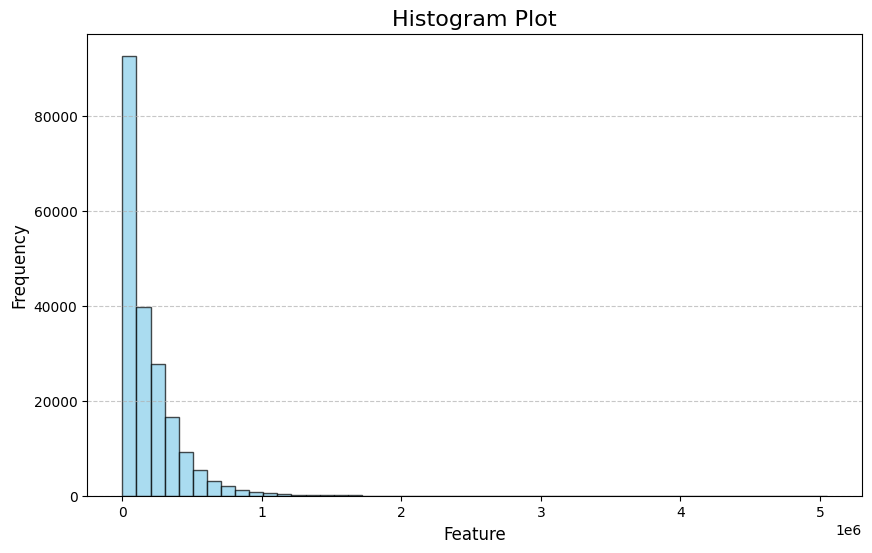

In [9]:
## histogram
histogram_plot(df, 'funds_after_6months')

* Classic long-tail (pareto) distribution.

### 2.3 Correlation

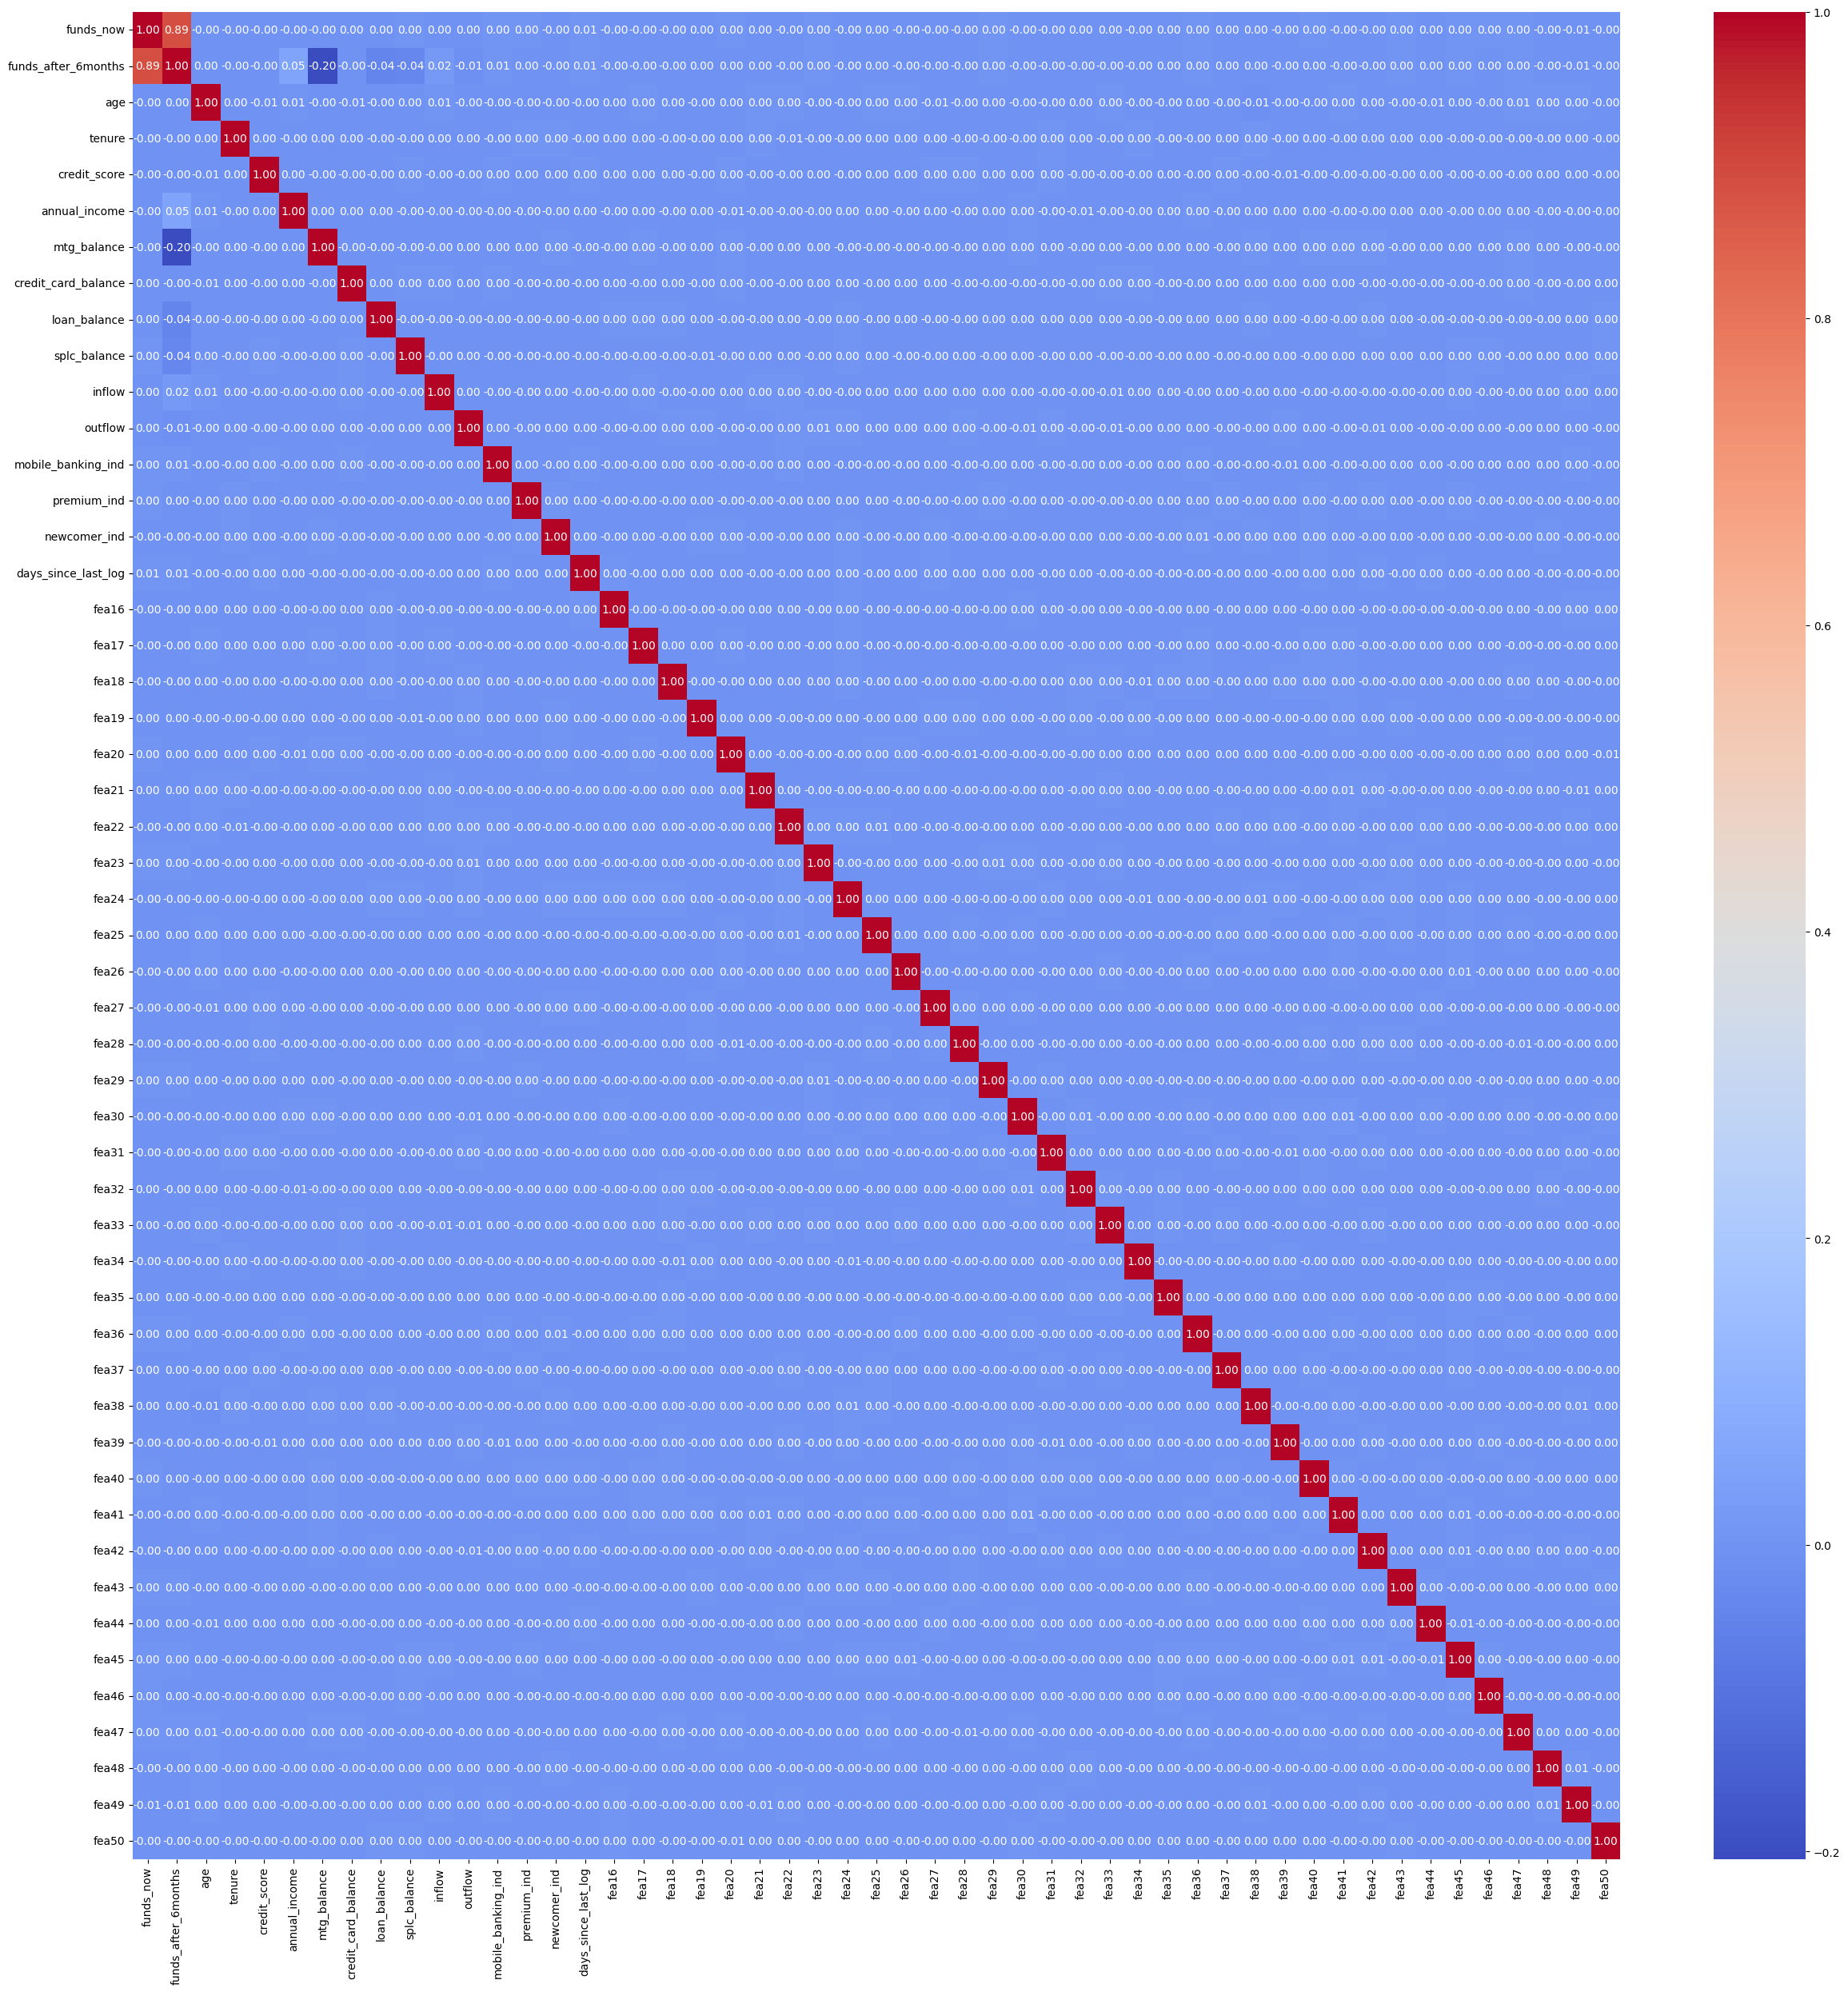

In [10]:
# remove id
df_corr = df.drop(columns=['id'])

# plot
plt.figure(figsize=(30, 30))  # Adjust the figure size
corr = df_corr.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

* No significant correlated features, except "funds_after_6months" and "funds_now".

### 2.4 Check for missing values

In [11]:
df.isnull().sum()

id                     0
funds_now              0
funds_after_6months    0
age                    0
tenure                 0
credit_score           0
annual_income          0
mtg_balance            0
credit_card_balance    0
loan_balance           0
splc_balance           0
inflow                 0
outflow                0
mobile_banking_ind     0
premium_ind            0
newcomer_ind           0
days_since_last_log    0
fea16                  0
fea17                  0
fea18                  0
fea19                  0
fea20                  0
fea21                  0
fea22                  0
fea23                  0
fea24                  0
fea25                  0
fea26                  0
fea27                  0
fea28                  0
fea29                  0
fea30                  0
fea31                  0
fea32                  0
fea33                  0
fea34                  0
fea35                  0
fea36                  0
fea37                  0
fea38                  0


### 2.5 Check for duplicated rows

In [12]:
df_no_dup = df.drop_duplicates()
df_no_dup.shape[0]

200000

In [13]:
len(df)

200000

### 2.6 Distribution of serveral features

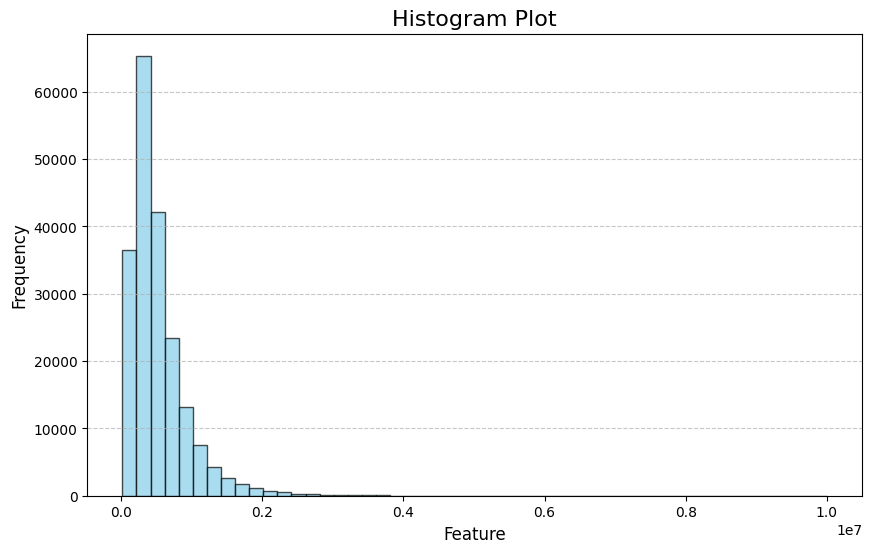

In [14]:
## histogram
histogram_plot(df, 'funds_now')

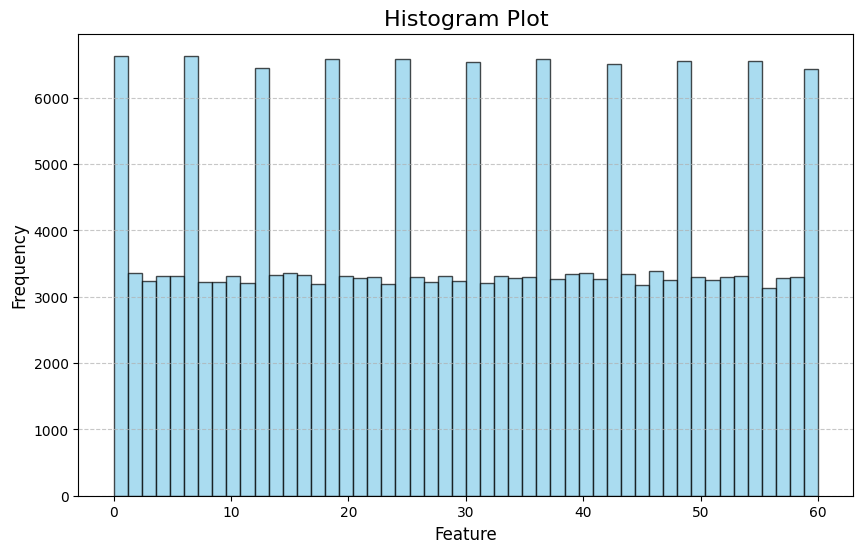

In [15]:
## histogram
histogram_plot(df, 'tenure')

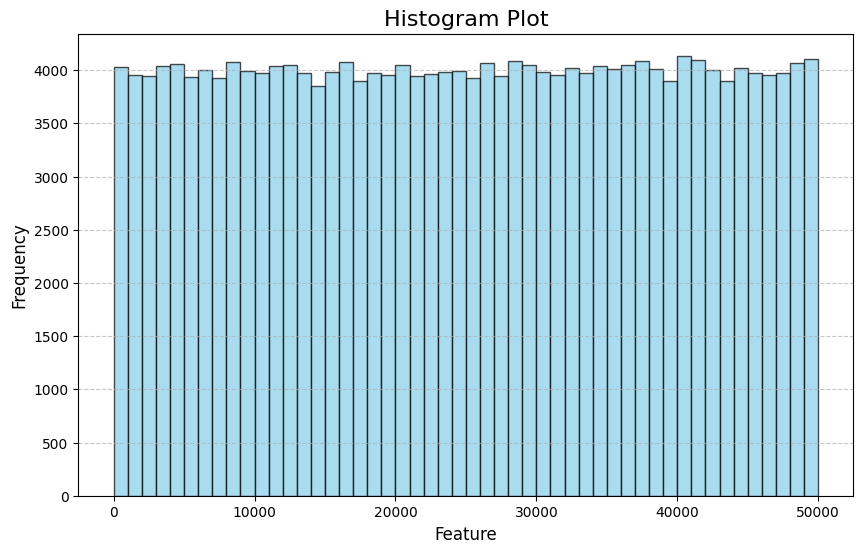

In [16]:
## histogram
histogram_plot(df, 'credit_card_balance')